# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations
from LookGenerator.networks.losses import PerceptualLoss, PerPixelLoss
from LookGenerator.datasets.encoder_decoder_datasets import EncoderDecoderDataset
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.clothes_feature_extractor import ClothAutoencoder
from LookGenerator.networks.encoder_decoder import EncoderDecoder
from LookGenerator.networks_training.utils import check_path_and_creat
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.utils import load_model

# Загрузка данных

In [2]:
from torchvision.transforms import InterpolationMode

transform_human = transforms.Compose([
    transforms.Resize((256, 192)) #,
    # transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

transform_pose_points=transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale()
])

transform_clothes = transforms.Compose([
    transforms.Resize((256, 192)),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_human_restored = transforms.Compose([
    transforms.Resize((256, 192)),
    # transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    custom_transforms.MinMaxScale()
])


In [3]:
batch_size_train = 32
batch_size_val = 16
pin_memory = True
num_workers = 12

In [4]:
train_dataset = EncoderDecoderDataset(
    image_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\train",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_human_restored=transform_human_restored
)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers
)

In [5]:
val_dataset = EncoderDecoderDataset(
    image_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\val",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_human_restored=transform_human_restored,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers
)

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 6, 256, 192])
torch.Size([32, 3, 256, 192])


# Лосс

In [7]:
class EncoderDecoderLoss(nn.Module):
    """
    Encoder-decoder custom loss
    """
    def __init__(self, device='cpu'):
        super(EncoderDecoderLoss, self).__init__()
        self.perceptual_loss = PerceptualLoss(device, weights_perceptual=[1.0, 1.0, 1.0, 1.0])
        self.per_pixel_loss = PerPixelLoss().to(device)

    def forward(self, outputs, targets):
        loss = self.perceptual_loss(outputs, targets) + self.per_pixel_loss(outputs, targets)
        return loss

# Обучение модели

In [8]:
clothes_feature_extractor = ClothAutoencoder(
    in_channels=3,
    out_channels=3,
    features=(8, 16, 32, 64),
    latent_dim_size=128,
    encoder_activation_func=nn.LeakyReLU(),
    decoder_activation_func=nn.ReLU()
)
clothes_feature_extractor = load_model(clothes_feature_extractor, r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\autoDegradation\weights\testClothes_L1Loss_4features\epoch_39.pt")

In [9]:
model = EncoderDecoder(clothes_feature_extractor, in_channels=6, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = EncoderDecoderLoss(device=device)
print(device)

C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [10]:
save_directory=r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\newEncoder\weights\testBaseParams"
check_path_and_creat(save_directory)

True

In [11]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [12]:
trainer = Trainer(
    model_=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_directory=save_directory,
    save_step=1,
    verbose=True
)

In [13]:
trainer.train(train_dataloader, val_dataloader, epoch_num=20)

start time 31-05-2023 01:07


  0%|          | 0/364 [00:00<?, ?it/s]C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 364/364 [05:04<00:00,  1.20it/s]


Epoch 0 of 19, train loss: 3.17834
Epoch end time 31-05-2023 01:12


100%|██████████| 127/127 [00:32<00:00,  3.87it/s]


Epoch 0 of 19, val loss: 3.60770
Epoch end time 31-05-2023 01:13


100%|██████████| 364/364 [03:34<00:00,  1.69it/s]


Epoch 1 of 19, train loss: 2.48497
Epoch end time 31-05-2023 01:16


100%|██████████| 127/127 [00:28<00:00,  4.44it/s]


Epoch 1 of 19, val loss: 3.02210
Epoch end time 31-05-2023 01:17


100%|██████████| 364/364 [05:32<00:00,  1.10it/s]


Epoch 2 of 19, train loss: 2.35142
Epoch end time 31-05-2023 01:23


100%|██████████| 127/127 [00:31<00:00,  4.04it/s]


Epoch 2 of 19, val loss: 2.43415
Epoch end time 31-05-2023 01:23


100%|██████████| 364/364 [04:38<00:00,  1.31it/s]


Epoch 3 of 19, train loss: 2.26341
Epoch end time 31-05-2023 01:28


100%|██████████| 127/127 [00:31<00:00,  3.98it/s]


Epoch 3 of 19, val loss: 6.62318
Epoch end time 31-05-2023 01:28


100%|██████████| 364/364 [03:52<00:00,  1.56it/s]


Epoch 4 of 19, train loss: 2.19914
Epoch end time 31-05-2023 01:32


100%|██████████| 127/127 [00:35<00:00,  3.55it/s]


Epoch 4 of 19, val loss: 2.52389
Epoch end time 31-05-2023 01:33


100%|██████████| 364/364 [04:27<00:00,  1.36it/s]


Epoch 5 of 19, train loss: 2.13978
Epoch end time 31-05-2023 01:37


100%|██████████| 127/127 [00:31<00:00,  4.01it/s]


Epoch 5 of 19, val loss: 2.74322
Epoch end time 31-05-2023 01:38


100%|██████████| 364/364 [04:50<00:00,  1.25it/s]


Epoch 6 of 19, train loss: 2.09545
Epoch end time 31-05-2023 01:43


100%|██████████| 127/127 [00:31<00:00,  3.98it/s]


Epoch 6 of 19, val loss: 2.76026
Epoch end time 31-05-2023 01:43


100%|██████████| 364/364 [04:12<00:00,  1.44it/s]


Epoch 7 of 19, train loss: 2.04971
Epoch end time 31-05-2023 01:47


100%|██████████| 127/127 [00:30<00:00,  4.11it/s]


Epoch 7 of 19, val loss: 3.84845
Epoch end time 31-05-2023 01:48


100%|██████████| 364/364 [03:41<00:00,  1.64it/s]


Epoch 8 of 19, train loss: 2.01116
Epoch end time 31-05-2023 01:51


100%|██████████| 127/127 [00:29<00:00,  4.34it/s]


Epoch 8 of 19, val loss: 2.45645
Epoch end time 31-05-2023 01:52


100%|██████████| 364/364 [03:33<00:00,  1.71it/s]


Epoch 9 of 19, train loss: 1.96675
Epoch end time 31-05-2023 01:56


100%|██████████| 127/127 [00:28<00:00,  4.46it/s]


Epoch 9 of 19, val loss: 2.21883
Epoch end time 31-05-2023 01:56


100%|██████████| 364/364 [03:40<00:00,  1.65it/s]


Epoch 10 of 19, train loss: 1.93161
Epoch end time 31-05-2023 02:00


100%|██████████| 127/127 [00:29<00:00,  4.31it/s]


Epoch 10 of 19, val loss: 2.92617
Epoch end time 31-05-2023 02:00


100%|██████████| 364/364 [03:24<00:00,  1.78it/s]


Epoch 11 of 19, train loss: 1.89439
Epoch end time 31-05-2023 02:04


100%|██████████| 127/127 [00:29<00:00,  4.29it/s]


Epoch 11 of 19, val loss: 2.34570
Epoch end time 31-05-2023 02:04


100%|██████████| 364/364 [03:29<00:00,  1.73it/s]


Epoch 12 of 19, train loss: 1.85665
Epoch end time 31-05-2023 02:08


100%|██████████| 127/127 [00:30<00:00,  4.15it/s]


Epoch 12 of 19, val loss: 3.43757
Epoch end time 31-05-2023 02:08


100%|██████████| 364/364 [03:44<00:00,  1.62it/s]


Epoch 13 of 19, train loss: 1.82397
Epoch end time 31-05-2023 02:12


100%|██████████| 127/127 [00:30<00:00,  4.23it/s]


Epoch 13 of 19, val loss: 2.22385
Epoch end time 31-05-2023 02:12


100%|██████████| 364/364 [04:33<00:00,  1.33it/s]


Epoch 14 of 19, train loss: 1.78484
Epoch end time 31-05-2023 02:17


100%|██████████| 127/127 [00:29<00:00,  4.32it/s]


Epoch 14 of 19, val loss: 2.17191
Epoch end time 31-05-2023 02:17


100%|██████████| 364/364 [03:40<00:00,  1.65it/s]


Epoch 15 of 19, train loss: 1.75177
Epoch end time 31-05-2023 02:21


100%|██████████| 127/127 [00:27<00:00,  4.55it/s]


Epoch 15 of 19, val loss: 2.51987
Epoch end time 31-05-2023 02:22


100%|██████████| 364/364 [03:14<00:00,  1.87it/s]


Epoch 16 of 19, train loss: 1.71858
Epoch end time 31-05-2023 02:25


100%|██████████| 127/127 [00:27<00:00,  4.57it/s]


Epoch 16 of 19, val loss: 2.16515
Epoch end time 31-05-2023 02:25


100%|██████████| 364/364 [03:09<00:00,  1.93it/s]


Epoch 17 of 19, train loss: 1.68560
Epoch end time 31-05-2023 02:28


100%|██████████| 127/127 [00:29<00:00,  4.36it/s]


Epoch 17 of 19, val loss: 2.89207
Epoch end time 31-05-2023 02:29


100%|██████████| 364/364 [03:17<00:00,  1.84it/s]


Epoch 18 of 19, train loss: 1.64930
Epoch end time 31-05-2023 02:32


100%|██████████| 127/127 [00:30<00:00,  4.14it/s]


Epoch 18 of 19, val loss: 2.50664
Epoch end time 31-05-2023 02:33


100%|██████████| 364/364 [03:24<00:00,  1.78it/s]


Epoch 19 of 19, train loss: 1.61979
Epoch end time 31-05-2023 02:36


100%|██████████| 127/127 [00:28<00:00,  4.38it/s]

Epoch 19 of 19, val loss: 2.16822
Epoch end time 31-05-2023 02:37
end time 31-05-2023 02:37
delta 1:29:16.585300


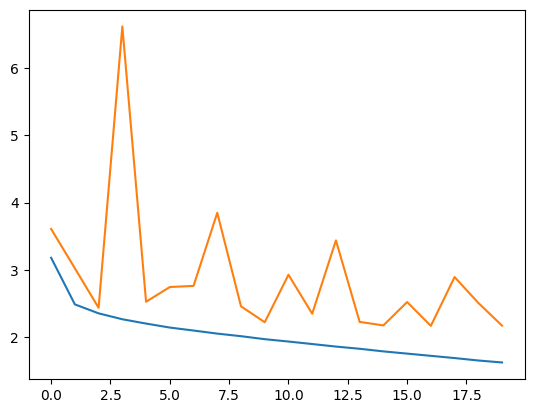

In [14]:
trainer.draw_history_plots()

In [15]:
print(str(trainer))

Model:
	Encoder-decoder: 
	base model 
Autoencoder: 
	features: (8, 16, 32, 64), latent_size: 128
Criterion: 
	<class '__main__.EncoderDecoderLoss'>
Optimizer: 
	<class 'torch.optim.adam.Adam'>


In [16]:
file = open(os.path.join(save_directory, "readme.txt"), 'w')
file.write(str(trainer))
file.close()

In [ ]:
trainer.train(train_dataloader, val_dataloader, epoch_num=20)

In [ ]:
trainer.draw_history_plots()